# Spotify Genre Classifier

## Setup

In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import walk, path
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [ ]:
# load data

# get all filenames from the directory data
f = []
for (dirpath, dirnames, filenames) in walk("data"):
    f.extend(filenames)
    break

# load data from all files from the directory data
frames = []
for file in f:
    data = pd.read_json(path.join("data", file))
    frames.append(data)

# concat all data into one dataframe
raw_data = pd.concat(frames, ignore_index=True)

## Visualization

### Clean Dataset

In [ ]:
raw_data.head()

In [ ]:
raw_data.columns

In [ ]:
# now drop some features which have no importance for the ML task
data = raw_data.drop(["uri", "id", "track_href", "analysis_url", "type"], axis=1)

In [ ]:
data.columns

In [ ]:
data.shape

In [ ]:
data.info()

In [100]:
categorical_features = {'key', 'mode', 'time_signature'}
numeric_features = set(data.columns) - categorical_features - {"genre"}

numeric_features = list(numeric_features)
categorical_features = list(categorical_features)

In [ ]:
# convert ms to sec
data.duration_ms /= 1000
data.rename(columns={"duration_ms": "duration_s"}, inplace=True)

In [ ]:
# remove samples with key == -1
print(f"Removed samples: {len(data[data.key == -1])}")
data = data[data.key != -1]

In [ ]:
# remove samples where time_signature is out of bounds [3:7]
print(f"Removed samples: {len(data[(data.time_signature < 3) | (data.time_signature > 7)])}")
data = data[(data.time_signature >= 3) & (data.time_signature <= 7)]

In [101]:
scaler = StandardScaler()
data[numeric_features] = scaler.fit_transform(data[numeric_features])
data.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s,time_signature
count,1496.000000,1.496000e+03,1496.000000,1.496000e+03,1496.000000,1.496000e+03,1.496000e+03,1496.000000,1.496000e+03,1.496000e+03,1.496000e+03,1.496000e+03,1496.000000
mean,0.000000,-1.139908e-16,5.324866,3.799694e-17,0.554813,2.279816e-16,2.279816e-16,0.000000,-7.599388e-17,9.499234e-17,-3.799694e-17,-1.519878e-16,3.922460
std,1.000334,1.000334e+00,3.553143,1.000334e+00,0.497153,1.000334e+00,1.000334e+00,1.000334,1.000334e+00,1.000334e+00,1.000334e+00,1.000334e+00,0.338208
min,-2.186014,-1.748385e+00,0.000000,-3.931178e+00,0.000000,-7.403000e-01,-8.916190e-01,-0.662630,-1.105465e+00,-1.457608e+00,-2.281974e+00,-1.513452e+00,3.000000
25%,-0.688061,-9.271401e-01,2.000000,-3.790043e-01,0.000000,-5.908137e-01,-8.663452e-01,-0.662630,-6.229652e-01,-9.188366e-01,-7.916032e-01,-6.165463e-01,4.000000
50%,-0.011304,3.100872e-01,5.000000,4.093495e-01,1.000000,-4.756200e-01,-6.227343e-01,-0.660284,-4.177242e-01,-7.159063e-02,-5.802375e-02,-2.795941e-01,4.000000
75%,0.708497,8.765470e-01,8.000000,7.021276e-01,1.000000,1.001073e-01,1.185761e+00,1.013255,3.652257e-01,8.103154e-01,8.455208e-01,2.521610e-01,4.000000
max,2.128970,1.284642e+00,11.000000,1.238519e+00,1.000000,8.137106e+00,1.576703e+00,1.996559,5.511073e+00,2.127398e+00,2.806809e+00,7.869757e+00,5.000000


### Outlier removal

### Statistics

In [ ]:
# if you want to compare statistic informations from specific features you can use: data.groupby('genre').describe()["feature1", "feature2", ...]
data.groupby('genre').describe()["duration_s"]

In [ ]:
data.describe()

### Plots

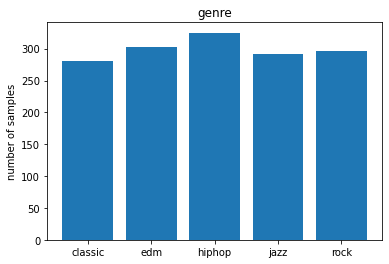

In [85]:
sorted_list = data["genre"].value_counts().sort_values().sort_index() # get the feature sorted
labels = sorted_list.index.tolist()
values = sorted_list.tolist()

plt.bar(labels, values)
plt.title("genre")
plt.ylabel("number of samples")
plt.show()

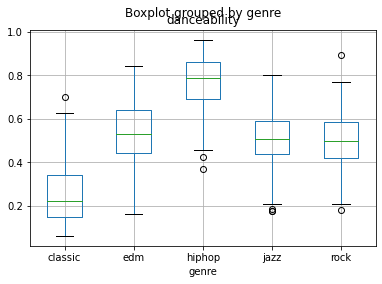

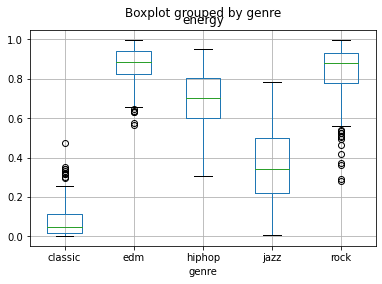

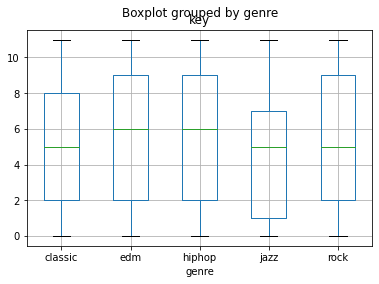

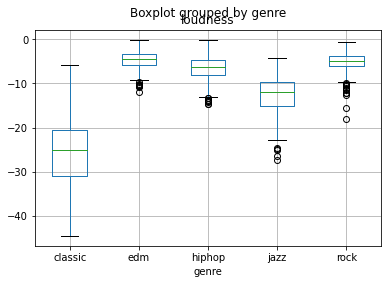

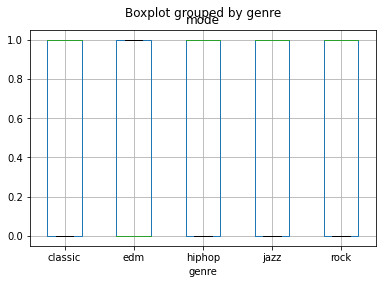

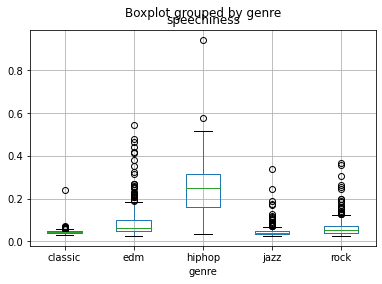

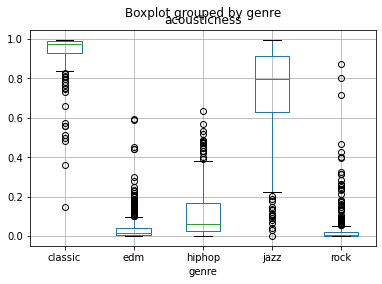

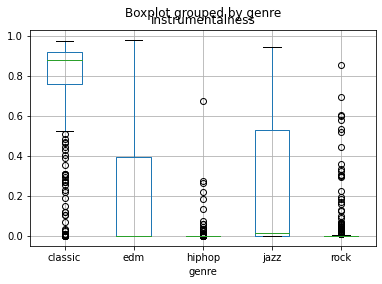

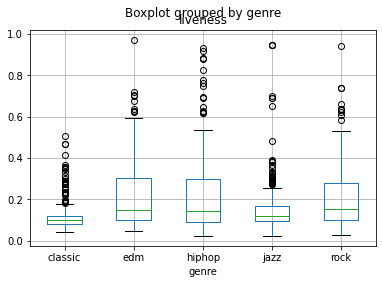

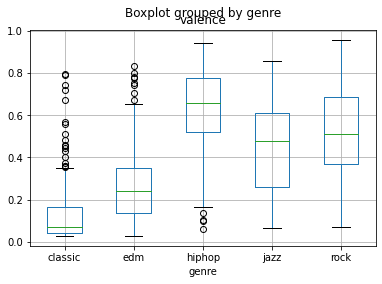

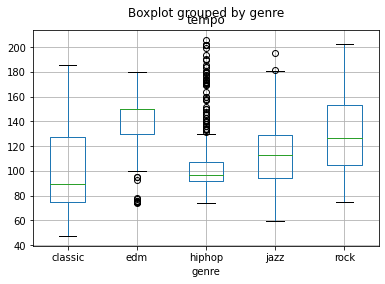

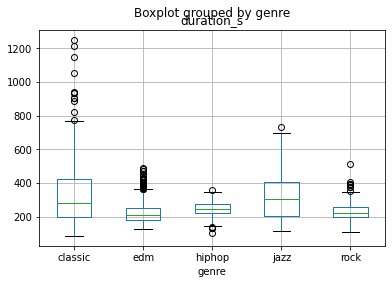

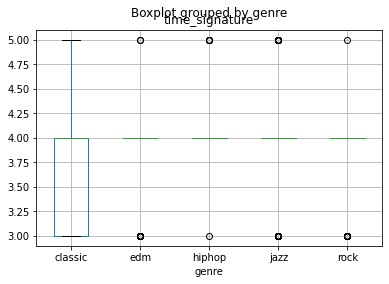

In [84]:
for feature in data.loc[:, data.columns != 'genre'].columns:
    data.boxplot(column=feature, by="genre")

In [ ]:
data.corr()

In [ ]:
fig = plt.figure()
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
fig.set_size_inches(15.5, 10.5, forward=True)

In [ ]:
sns.pairplot(data=data, hue="genre")

## Model Selection

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

X = data.iloc[:,:13]
y = data.genre

print(cross_val_score(RandomForestClassifier(n_estimators=1000), X, y, cv=10))

In [ ]:
# Pipeline
pipe = Pipeline([('scaler', StandardScaler()), ('svc', RandomForestClassifier())])
X = data.iloc[:,:13]
y = data.genre
print(cross_val_score(pipe, X, y, cv=10))

#pipe.fit(X_train, y_train)
#pipe.score(X_test, y_test)